# MNIST CNN with Visdom

### import visdom

In [1]:
import visdom

vis = visdom.Visdom()
vis.close(env="main")

Setting up a new session...


''

### define loss_tracker

num, loss_value are Tensor

In [2]:

def loss_tracker(loss_plot, loss_value, num):
    vis.line(X=num,
             Y=loss_value,
             win = loss_plot,
             update='append'
             )

In [3]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torch.nn.init

device = 'cpu'

### Parameters

In [4]:
learning_rate = 0.001
training_epochs = 15
batch_size = 32

### Load MNIST Dataset

    root = "*"
경로는 개인에 맞게 변경,   

    download=True/False
처음 코드 작성할 때는 필요하나, 이미 저장했기 때문에 False로 입력 

In [5]:
mnist_train = dsets.MNIST(root='/tmp/pycharm_project/MNIST_data/',
                         train = True,
                         transform=transforms.ToTensor(),
                         download=True)

mnist_test = dsets.MNIST(root='/tmp/pycharm_project/MNIST_data/',
                        train=False,
                        transform = transforms.ToTensor(),
                        download=True)

In [6]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size = batch_size,
                                          shuffle =True,
                                          drop_last=True)

### CNN Moddel Configuration

In [7]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(3*3*128, 625)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(625, 10, bias =True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [8]:
model = CNN().to(device)

value = (torch.Tensor(1,1,28,28)).to(device)
print( (model(value)).shape )

torch.Size([1, 10])


In [9]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

### Make plot

In [10]:
loss_plt = vis.line(Y=torch.Tensor(1).zero_(),opts=dict(title='loss_tracker', legend=['loss'], showlegend=True))

### Train with loss_tracker

In [11]:
total_batch = len(data_loader)

for epoch in range(training_epochs):
    avg_cost = 0
    
    for X, Y in data_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer.zero_grad()
        hypothesis = model(X)
        
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
    
    print('[Epoch:{}] cost = {}'.format(epoch+1, avg_cost))
    loss_tracker(loss_plt, torch.Tensor([avg_cost]), torch.Tensor([epoch]))
print('Learning Finished!')

[Epoch:1] cost = 0.12107331305742264
[Epoch:2] cost = 0.041568025946617126
[Epoch:3] cost = 0.028604142367839813
[Epoch:4] cost = 0.022846553474664688
[Epoch:5] cost = 0.01798403263092041
[Epoch:6] cost = 0.0144734438508749
[Epoch:7] cost = 0.01258626114577055
[Epoch:8] cost = 0.010470787063241005
[Epoch:9] cost = 0.01021922379732132
[Epoch:10] cost = 0.008028729818761349
[Epoch:11] cost = 0.00868416577577591
[Epoch:12] cost = 0.006564615294337273
[Epoch:13] cost = 0.008405051194131374
[Epoch:14] cost = 0.007567551452666521
[Epoch:15] cost = 0.0055738789960742
Learning Finished!


In [12]:
with torch.no_grad():
    X_test = mnist_test.data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.targets.to(device)
    
    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean() 
    print('Accuracy:', accuracy.item())

Accuracy: 0.9265000224113464


### Output Image 

In [13]:
from IPython.display import Image

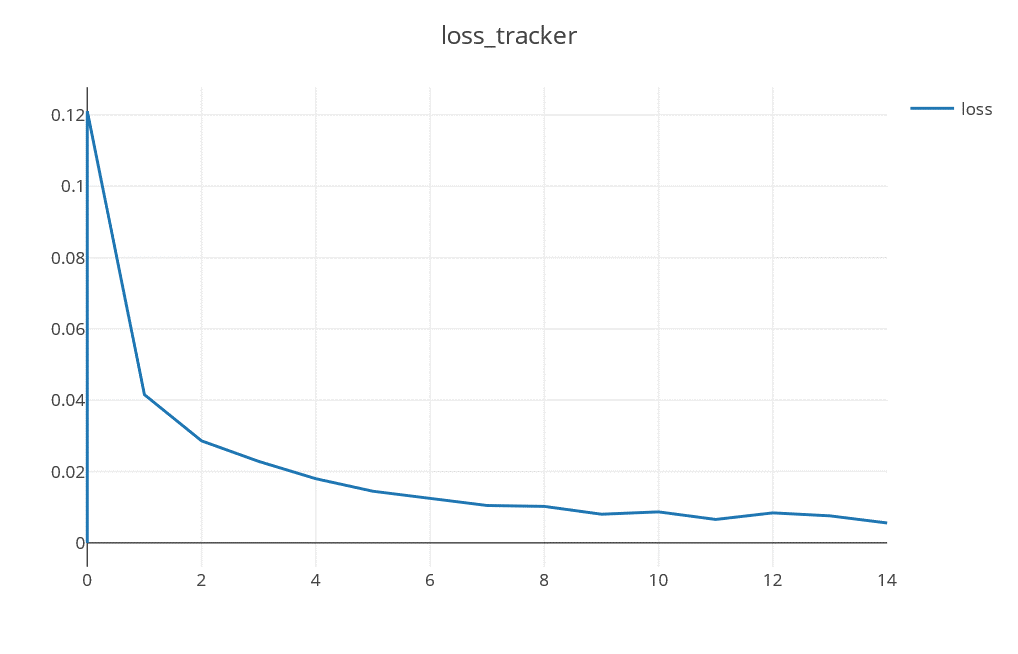

In [14]:
Image("img/2020-07-14-1.png")